# **"SNCF : Objets perdus"**

In [70]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from folium import plugins, Map, FeatureGroup, Marker, LayerControl
import branca
import plotly.express as px
from sklearn.linear_model import LinearRegression
from PIL import Image

## **1. Description des 7 colonnes du fichier des objets trouvés.**

Dans le fichier 'objets trouvés' nous avons 7 colonnes composées de :
1. 'Date', qui correspond à la date et l'heure de la déclaration d'objet perdu sur le site 'trouv.com' par les individus.
2. 'Date et heure de restitution', qui correspond à la date et l'heure de la restitution au voyageur de l'objet perdu.
3. 'Gare',le nom de la gare que l'individu à sélectionné lorsqu'il a effectué la déclaration d'objet perdu.
4. 'Code IUC', qui correspond à l'"identification unique client", ici chaque gare a un numéro unique qui permet de l'identifier.
5. 'Nature d'objet', qui correspond à l'objet perdu
6. 'Type d'objet', on y trouve les différentes catégories de type d'objets trouvé comme 'Papiers et documents officiels' qui comprend différentes natures d'objets (carte d'identité, passeport, ...)
7. 'Type d'enregistrement', montre si l'objet a été retrouvé

## **2. Charger le jeu de données en *pandas***

In [71]:
dataframe_1 = pd.read_csv('objets-trouves-restitution.csv', sep = ';')
dataframe_1.head()

Date Date et heure de restitution  \
0  2018-01-04T22:18:50+01:00                          NaN   
1  2018-01-05T05:51:16+01:00                          NaN   
2  2018-01-05T06:43:28+01:00                          NaN   
3  2018-01-05T06:49:34+01:00                          NaN   
4  2018-01-05T08:44:24+01:00                          NaN   

                     Gare    Code UIC                        Nature d'objets  \
0  Montpellier Saint-Roch  87773002.0                        Autre bagagerie   
1                    Caen  87444000.0                       Foulard, écharpe   
2               Tourcoing  87286542.0                           Carte Vitale   
3               Tourcoing  87286542.0  Sacoche pour ordinateur, photo, vidéo   
4            Lille Europe  87223263.0                     Carte d'abonnement   

                              Type d'objets Type d'enregistrement  
0       Bagagerie: sacs, valises, cartables          Objet trouvé  
1                     Vêtements, chaussures          Objet trouvé  
2  Pièces d'identités et papiers personnels          Objet trouvé  
3       Bagagerie: sacs, valises, cartables          Objet trouvé  
4  Pièces d'identités et papiers personnels          Objet trouvé

Nous constatons que toutes les colonnes sont séparées par des ';'.
Donc nous exécutons une commande qui permet de lire le fichier et de séparer les différentes colonnes de variable avec le séparateur 'sep'.

De plus, il y a des valeurs manquantes dans la colonne 'Date et heure de restitution', ce qui signifie qu'il y a des objets perdus qui ont été trouvés, mais pas restitués.

## **3. Description du jeu de données**

### **Architecture du DataFrame**

In [72]:
#dimensions : nombre de lignes, nombre de colonnes
dataframe_1.shape

(696414, 7)

Dans le DataFrame, nous avons 7 colonnes et 696 414 lignes, soit 696 414 déclarations car nous prenons pas en compte l'index.

### **Informations sur les données**

In [73]:
dataframe_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696414 entries, 0 to 696413
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date                          696414 non-null  object 
 1   Date et heure de restitution  239297 non-null  object 
 2   Gare                          696123 non-null  object 
 3   Code UIC                      696123 non-null  float64
 4   Nature d'objets               696414 non-null  object 
 5   Type d'objets                 696414 non-null  object 
 6   Type d'enregistrement         696414 non-null  object 
dtypes: float64(1), object(6)
memory usage: 37.2+ MB


Cette commande nous montre : les différentes colonnes, le nombre d'éléments qu'elle contient, son type. Il y a 6 colonnes qui contiennent du texte (object()) et une colonne qui contient des nombres (float64()).

Nous pouvons constater qu'il y a des valeurs manquantes dans des colonnes du DataFrame, car chaque colonne ne possède pas tous les 696 414 éléments.
Nous allons examiner ces valeurs manquantes. Pour cela, nous pouvons réaliser une commander qui permet de calculer la somme des valeurs manquantes dans chaque colonne du dataframe_1.

### **Valeurs manquantes**

In [74]:
nombre_nul = pd.DataFrame(dataframe_1.isnull().sum()).rename(columns = {0:"Nombre"}) #somme des valeurs nulles dans chaque colonne
pourc_nul = pd.DataFrame(dataframe_1.isnull().sum()/len(dataframe_1)*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

valeurs_manquantes = pd.merge(nombre_nul, pourc_nul, how='left', left_index=True, right_index=True)
valeurs_manquantes

Nombre Pourcentage
Date                               0        0.0%
Date et heure de restitution  457117    65.6387%
Gare                             291     0.0418%
Code UIC                         291     0.0418%
Nature d'objets                    0        0.0%
Type d'objets                      0        0.0%
Type d'enregistrement              0        0.0%

Nous pouvons constater qu'il y a beaucoup de valeurs manquantes dans la colonne 'Date et heure de restitution', soit 457 117. Ce qui signifie qu'il y a 457 117 objets trouvés qui n'ont pas été rendu, soit 65% des objets trouvés.
De plus, nous pouvons constater que lors des déclarations d'objets perdus, il y a des individus qui n'ont pas spécifié la gare du lieu de la perte de l'objet.

### **Variable 'Gare'**

Dans un premier temps, nous constatons que différentes gares reviennent plusieurs fois. Nous pouvons analyser le nombre de fois que chacune d'elles apparaît.

In [75]:
nombre_gare = pd.DataFrame(dataframe_1[["Gare"]].value_counts()).rename(columns = {0:"Nombre"})
pourc_gare = pd.DataFrame(dataframe_1[["Gare"]].value_counts()/len(dataframe_1["Gare"])*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

var_gare = pd.merge(nombre_gare, pourc_gare, how='left', left_index=True, right_index=True)
var_gare.head()

Nombre Pourcentage
Gare                                  
Paris Gare de Lyon   53111     7.6264%
Paris Montparnasse   49565     7.1172%
Paris Gare du Nord   40424     5.8046%
Strasbourg           31358     4.5028%
Paris Saint-Lazare   29049     4.1712%

In [76]:
len(var_gare)

181

L'index est déjà dans l'ordre décroissant en fonction du nombre d'objets trouvés grâce à la fonction 'value_counts()'. Nous pouvons donc utiliser .index[0] pour donner la première ligne de l'index afin d'avoir la gare qui possède le plus d'objets trouvés.

In [77]:
var_gare.index[0]

('Paris Gare de Lyon',)

In [78]:
var_gare.max()

Nombre           53111
Pourcentage    7.6264%
dtype: object

In [79]:
var_gare.index[-1]

('Forbach',)

In [80]:
var_gare.min()

Nombre               1
Pourcentage    0.0001%
dtype: object

Il y a 181 gares différentes déclarées. La gare de 'Paris Gare de Lyon' est la gare où il y a le plus d'objets trouvés, elle représente 7,63% des gares.
La gare de Forbach est la gare où il y a le moins d'objets trouvés.

### **Cardinalité des variables 'Gare' et 'Code_UIC'**

Nous allons réaliser un dataframe pour attribuer à chaque gare leur code UIC correspondant, ainsi que le volume

In [81]:
nombre_gares_trouves = pd.DataFrame(dataframe_1[["Gare", "Code UIC"]].value_counts()).rename(columns = {0:"Nombre"})
Pourc_gares_trouves = pd.DataFrame(dataframe_1[["Gare", "Code UIC"]].value_counts()/len(dataframe_1[["Gare", "Code UIC"]])*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

Gares_trouves = pd.merge(nombre_gares_trouves, Pourc_gares_trouves, how='left', left_index=True, right_index=True)
Gares_trouves.head()

Nombre Pourcentage
Gare               Code UIC                      
Paris Gare de Lyon 87686006.0   53111     7.6264%
Paris Montparnasse 87391003.0   49565     7.1172%
Paris Gare du Nord 87271007.0   40424     5.8046%
Strasbourg         87212027.0   31358     4.5028%
Paris Saint-Lazare 87384008.0   29049     4.1712%

Nous pouvons observer le Code UIC attribué à chaque gare, le nombre de fois qu'elles apparaissent, ainsi que son pourcentage.

### **Types d'objets**

Nous étudions maintenant la variable "types d'objets". Nous pouvons calculer le volume d'objets perdus par type d'objet

In [82]:
nombre_objets_trouves = pd.DataFrame(dataframe_1[["Type d'objets"]].value_counts()).rename(columns = {0:"Nombre"})
Pourc_objets_trouves = pd.DataFrame(dataframe_1[["Type d'objets"]].value_counts()/len(dataframe_1[["Type d'objets"]])*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

types_trouves = pd.merge(nombre_objets_trouves, Pourc_objets_trouves, how='left', left_index=True, right_index=True)
types_trouves.head()

Nombre Pourcentage
Type d'objets                                                         
Bagagerie: sacs, valises, cartables                 208277    29.9071%
Appareils électroniques, informatiques, apparei...  102348    14.6964%
Vêtements, chaussures                                90550    13.0023%
Porte-monnaie / portefeuille, argent, titres         82833    11.8942%
Pièces d'identités et papiers personnels             61992     8.9016%

In [83]:
len(types_trouves)

16

Nous avons 16 catégories de type d'objets.

In [84]:
types_trouves.index[0]

('Bagagerie: sacs, valises, cartables',)

In [85]:
types_trouves.max()

Nombre          208277
Pourcentage    8.9016%
dtype: object

In [86]:
types_trouves.index[-1]

('Instruments de musique',)

In [87]:
types_trouves.min()

Nombre            1853
Pourcentage    0.2661%
dtype: object

Le type d'objet 'Bagagerie' est la catégorie qui est la plus trouvée, elle représente 29,91% des types d'objets les plus trouvés. 'Instruments de musique' est la catégorie la moins trouvée parmi les types d'objets trouvés, elle représente 0,27% des types d'objets les plus trouvés.

### **Nature d'objets**

Nous étudions les différentes natures d'objets. Nous pouvons calculer le volume d'objets perdus par nature d'objet.

In [88]:
nombre_nature_trouves = pd.DataFrame(dataframe_1[["Nature d'objets"]].value_counts()).rename(columns = {0:"Nombre"})
Pourc_nature_trouves = pd.DataFrame(dataframe_1[["Nature d'objets"]].value_counts()/len(dataframe_1[["Nature d'objets"]])*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

nature_trouves = pd.merge(nombre_nature_trouves, Pourc_nature_trouves, how='left', left_index=True, right_index=True)
nature_trouves.head()

Nombre Pourcentage
Nature d'objets                                                 
Porte-monnaie, portefeuille                    64089     9.2027%
Sac à dos                                      56902     8.1707%
Téléphone portable                             56375      8.095%
Valise, sac sur roulettes                      46766     6.7153%
Manteau, veste, blazer, parka, blouson, cape   45375     6.5155%

In [89]:
len(nature_trouves)

131

In [90]:
nature_trouves.index[0]

('Porte-monnaie, portefeuille',)

In [91]:
nature_trouves.max()

Nombre           64089
Pourcentage    9.2027%
dtype: object

In [92]:
nature_trouves.index[-1]

('Ordinateur, ordinateur portable, notebook protégé (étui, housse,?)',)

In [93]:
nature_trouves.min()

Nombre               1
Pourcentage    0.0001%
dtype: object

Nous avons 131 natures d'objets

Le porte monnaie et porte feuille font partie des natures d'objets les plus perdus parmi tout les natures d'objets, soit 9,2%. 

### **Cardinalité des variables 'type d'objets' et 'nature d'objets'**

Nous pouvons donc réaliser un dataframe pour regrouper tout les 'nature d'objet' dans leur 'type d'objets'. Pour cela, nous pouvons trier les différentes catégories d'objets puis leur attribués les natures d'objet afin de les regrouper.

In [94]:
#nombre et pourcentage de nature d'objets dans chaque type d'objets
nombre_types_objets = pd.DataFrame(dataframe_1[["Type d'objets", "Nature d'objets"]].value_counts()).rename(columns = {0:"Nombre"})
pourc_types_objets = pd.DataFrame(dataframe_1[["Type d'objets", "Nature d'objets"]].value_counts()/len(dataframe_1[["Type d'objets", "Nature d'objets"]])*100).round(4).rename(columns = {0:"Pourcentage"}).astype(str) + '%'

card_type_nature = pd.merge(nombre_types_objets, pourc_types_objets, how='left', left_index=True, right_index=True)

#regroupement de chaque nature d'objet dans chaque type d'objet
objets = card_type_nature.groupby(["Type d'objets", "Nature d'objets"])
objets.first()

Nombre  \
Type d'objets                                      Nature d'objets                                              
Appareils électroniques, informatiques, apparei... AirPod, casque audio, écouteurs                       1066   
                                                   Appareil audio portable (lecteur de CD, baladeu...    1586   
                                                   Appareil photo, caméscope/caméras et accessoires      1627   
                                                   Appareil photo, caméscope/caméras et accessoire...       1   
                                                   Appareil photo, caméscope/caméras et accessoire...    1299   
...                                                                                                       ...   
Vêtements, chaussures                              Foulard, écharpe                                     12047   
                                                   Gants                                                 3052   
                                                   Housse de vêtement                                     215   
                                                   Manteau, veste, blazer, parka, blouson, cape         45374   
                                                   Pull over, gilet                                      8486   

                                                                                                      Pourcentage  
Type d'objets                                      Nature d'objets                                                 
Appareils électroniques, informatiques, apparei... AirPod, casque audio, écouteurs                        0.1531%  
                                                   Appareil audio portable (lecteur de CD, baladeu...     0.2277%  
                                                   Appareil photo, caméscope/caméras et accessoires       0.2336%  
                                                   Appareil photo, caméscope/caméras et accessoire...     0.0001%  
                                                   Appareil photo, caméscope/caméras et accessoire...     0.1865%  
...                                                                                                           ...  
Vêtements, chaussures                              Foulard, écharpe                                       1.7299%  
                                                   Gants                                                  0.4382%  
                                                   Housse de vêtement                                     0.0309%  
                                                   Manteau, veste, blazer, parka, blouson, cape           6.5154%  
                                                   Pull over, gilet                                       1.2185%  

[138 rows x 2 columns]

Grâce à ce Dataframe nous pouvons observer plus facilement les sous-catégories (nature d'objets) des catégories (type d'objets), ainsi que le volume.

## **4. Conversion des colonnes 'Date' et 'Date et heure de restitution' sous format de date plus utilisable.**

In [95]:
#Conversion de la colonne 'Date' sous format date
dataframe_1['Date'] = pd.to_datetime(dataframe_1['Date'], utc=True)
dataframe_1['Date'] = dataframe_1['Date'].dt.strftime('%Y-%m-%d')

#Conversion de la colonne 'Date et heure de restitution'. Nous gardons l'heure ici car ça fait partie de l'intitulé de la colonne 
dataframe_1['Date et heure de restitution'] = pd.to_datetime(dataframe_1['Date et heure de restitution'], utc=True)
dataframe_1['Date et heure de restitution'] = dataframe_1['Date et heure de restitution'].dt.strftime('%Y-%m-%d %H:%M:%S')

dataframe_1.head()

Date Date et heure de restitution                    Gare  \
0  2018-01-04                          NaN  Montpellier Saint-Roch   
1  2018-01-05                          NaN                    Caen   
2  2018-01-05                          NaN               Tourcoing   
3  2018-01-05                          NaN               Tourcoing   
4  2018-01-05                          NaN            Lille Europe   

     Code UIC                        Nature d'objets  \
0  87773002.0                        Autre bagagerie   
1  87444000.0                       Foulard, écharpe   
2  87286542.0                           Carte Vitale   
3  87286542.0  Sacoche pour ordinateur, photo, vidéo   
4  87223263.0                     Carte d'abonnement   

                              Type d'objets Type d'enregistrement  
0       Bagagerie: sacs, valises, cartables          Objet trouvé  
1                     Vêtements, chaussures          Objet trouvé  
2  Pièces d'identités et papiers personnels          Objet trouvé  
3       Bagagerie: sacs, valises, cartables          Objet trouvé  
4  Pièces d'identités et papiers personnels          Objet trouvé

## **5. Date de début du jeu de données.**

In [96]:
dataframe_1['Date'].min()

'2013-05-24'

La première date du jeu de donnée est le 24 mai 2013. Nous pouvons supposer la création de la page web pour effectuer les déclarations de pertes au alentour de cette date.

## **6. Analyse sur le jeu de données des objets trouvés mais aussi des objets déclarés perdus.**

In [97]:
#chargement du deuxième jeu de donnée, le fichier des objets déclaré perdu
dataframe_2 = pd.read_csv('objets-trouves-gares.csv', sep = ';')

In [98]:
#conversion de la colonne 'Date' sous format de date plus utilisable
dataframe_2['Date'] = pd.to_datetime(dataframe_2['Date'], utc = True)
dataframe_2['Date'] = dataframe_2['Date'].dt.strftime('%Y-%m-%d')
dataframe_2.head()

Date             Gare    Code UIC  \
0  2018-09-04         Mulhouse  87182063.0   
1  2017-03-22              NaN         NaN   
2  2018-09-04         Mulhouse  87182063.0   
3  2017-03-22              NaN         NaN   
4  2018-09-04  Bourg-en-Bresse  87743005.0   

                                   Nature d'objets  \
0            Sac d'enseigne (plastique, papier, …)   
1                        Valise, sac sur roulettes   
2       Téléphone portable protégé (étui, coque,…)   
3                               Téléphone portable   
4  Carte d'identité, passeport, permis de conduire   

                                       Type d'objets Type d'enregistrement  
0                Bagagerie: sacs, valises, cartables  Déclaration de Perte  
1                Bagagerie: sacs, valises, cartables  Déclaration de Perte  
2  Appareils électroniques, informatiques, appare...  Déclaration de Perte  
3  Appareils électroniques, informatiques, appare...  Déclaration de Perte  
4           Pièces d'identités et papiers personnels  Déclaration de Perte

### **a. Année, mois et jour de la semaine où il y a le plus d’objets trouvés et déclarés perdus.**

### **Objets perdus et trouvés par an**

In [99]:
dataframe_1['Date'] = pd.to_datetime(dataframe_1['Date'], utc = True)
Trouves_par_an = dataframe_1['Date'].groupby([dataframe_1.Date.dt.year]).count()

#Année avec le plus d'objets trouvés
Trouves_par_an.idxmax()

2015

In [100]:
dataframe_2['Date'] = pd.to_datetime(dataframe_2['Date'], utc = True)
Perdus_par_an = dataframe_2['Date'].groupby([dataframe_2.Date.dt.year]).count()

#Année avec le plus d'objets perdus
Perdus_par_an.idxmax()

2017

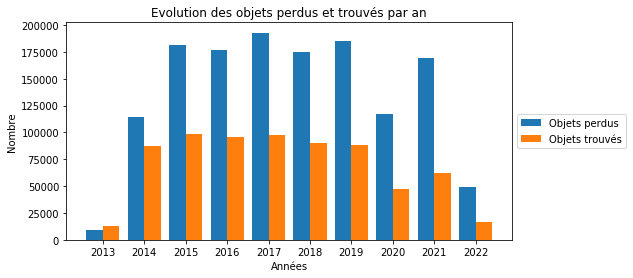

In [101]:
#création du graphique
fig_année, ax = plt.subplots(figsize = (8,4))
ax.bar(Perdus_par_an.index - 0.2, Perdus_par_an, width = 0.4, label='Objets perdus')
ax.bar(Trouves_par_an.index + 0.2, Trouves_par_an, width = 0.4, label='Objets trouvés')

ax.set_ylabel('Nombre')
ax.set_xlabel('Années')
ax.set_title("Evolution des objets perdus et trouvés par an")
ax.set_xticks(Perdus_par_an.index)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #affichage de la légende et son emplacement

plt.show()

Nous pouvons constater que pour l'année 2013, nous avons plus d'objets trouvés que d'objet perdu. Cela peut résulter du fait que des agents aient trouvés des objets sans que personne n'ait fait une déclaration d'objets perdus.

Nous pouvons observer que de l'année 2013 à 2015, nous avons une forte hausse des objets perdus et trouvés. Cela ne traduit pas que le nombre réel d'objets perdu ou trouvé est augmenté, mais de l'efficacité du nouveau dispositif mit en place. Ce qui permet aux voyageurs de déclarer une perte d'objet.

De 2015 à 2021, nous avons globalement une 'stagnation', sans compter l'année 2020 du au confinement et à la baisse des offres de trajets

### **Objets perdus et trouvés par mois**

In [102]:
Trouves_par_mois = dataframe_1['Date'].groupby([dataframe_1.Date.dt.month_name()]).count()

#Le mois avec le plus d'objets trouvés
Trouves_par_mois.idxmax()

'July'

In [103]:
Perdus_par_mois = dataframe_2['Date'].groupby([dataframe_2.Date.dt.month_name()]).count()

#Le mois avec le plus d'objets perdus
Perdus_par_mois.idxmax()

'July'

Les mois sont rangés dans l'ordre alphabétiques donc nous allons remettre dans l'ordre que nous souhaitons l'index 'Date', ici dans l'ordre des mois. Afin que ce soit plus cohérent sur le graphique.

In [104]:
# Variable avec les noms de l'index dans l'odre que l'on souhaite
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# On re index avec notre variable 'month' pour mettre dans l'odre
Perdus_par_mois = Perdus_par_mois.reindex(months)
Trouves_par_mois = Trouves_par_mois.reindex(months)

Nous avons les jours de la semaine dans l'ordre que l'on souhaite avec les valeurs correspondantes

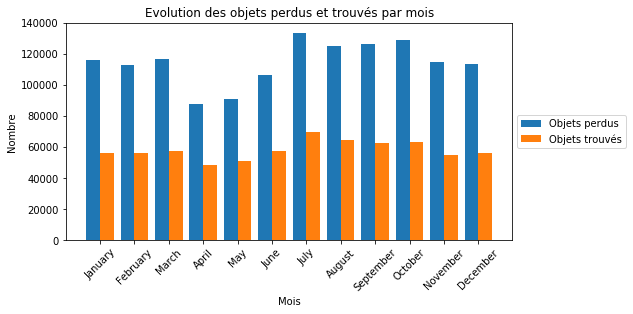

In [105]:
#création du graphique

labels = Perdus_par_mois.index    #l'index de 'Perdus_par_mois' et "Trouvés_par_mois" est le même, on utilise un des deux
x = np.arange(len(labels))    #on transforme notre index en nombre pour effectuer l'opération 'x+/- 0.2' pour l'affichage de deux colonnes

fig_mois, ax = plt.subplots(figsize=(8,4))
ax.bar(x - 0.2, Perdus_par_mois, width = 0.4, label='Objets perdus')
ax.bar(x + 0.2, Trouves_par_mois, width = 0.4, label='Objets trouvés')

ax.set_ylabel('Nombre')
ax.set_xlabel('Mois')
ax.set_title("Evolution des objets perdus et trouvés par mois")
ax.set_xticks(x)   #affichage de tous les indices de l'axe x
ax.set_xticklabels(labels, rotation='45')    #on remet les labels sur les ticks de l'axe x
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Le mois avec le plus d'objets perdus et trouvés est le mois de Juillet. Cela s'explique par le fait que c'est durant les grandes vacances d'été de nombreuses personnes partent en vacances, donc il y a plus d'affluence dans les gares.

### **Objets perdus et trouvés par jours**

In [106]:
Trouves_par_jours = dataframe_1['Date'].groupby([dataframe_1.Date.dt.day_name()]).count()
Trouves_par_jours.idxmax()

'Monday'

In [107]:
Perdus_par_jours = dataframe_2['Date'].groupby([dataframe_2.Date.dt.day_name()]).count()
Perdus_par_jours.idxmax()

'Monday'

Les jours sont rangés dans l'ordre alphabétiques donc nous allons remettre dans l'ordre que nous souhaitons l'index 'Date', ici dans l'odre des jours de la semaine. Afin que ce soit plus cohérent sur le graphique.

In [108]:
# Variable avec noms de l'index dans l'odre que l'on souhaite
week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 
# On re index avec notre variable 
Perdus_par_jours = Perdus_par_jours.reindex(week) 
Trouves_par_jours = Trouves_par_jours.reindex(week)

Nous avons les jours de la semaine dans l'odre que l'on souhaite avec les valeurs correspondantes

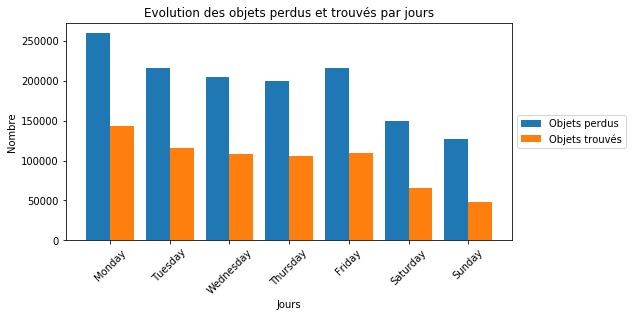

In [109]:
labels = Perdus_par_jours.index   #l'index de 'Perdus_par_jours' et "Trouvés_par_jours" est le même, on utilise un des deux
x = np.arange(len(labels))   #on transforme notre index en nombre pour effectuer l'opération 'x+/- 0.2' pour l'affichage de deux colonnes

fig_jours, ax = plt.subplots(figsize=(8,4))
ax.bar(x - 0.2, Perdus_par_jours, width = 0.4, label='Objets perdus') 
ax.bar(x + 0.2, Trouves_par_jours, width = 0.4, label='Objets trouvés')

ax.set_ylabel('Nombre')
ax.set_xlabel('Jours')
ax.set_title("Evolution des objets perdus et trouvés par jours")
ax.set_xticks(x)   #affichage de tous les indices de l'axe x
ax.set_xticklabels(labels, rotation='45')   #on remet les labels sur les ticks de l'axe x
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

Nous pouvons observer que le jour où il y a le plus d'objets perdus est le lundi.
Cela peut s'expliquer que le lundi de nombreux voyageurs part sur leur lieu de travail (ou d'étude) pour la semaine, et donc il y plus de déclarations de pertes d'objets le lundi. De même, le jour où il y a le plus d'objets trouvés est le lundi. Donc cela n'est pas très étonnant que le jour où il y a le plus d'objets trouvés est le même que celui où il y a le plus d'objets perdus.

### **b. Création d'un graphique pour montrer l’évolution du nombres d’objets déclarés perdus, trouvés et restitué depuis le début du jeu de donnée.**

Nous allons d'abord observer l'évolution au jour près. Pour cela, nous pouvons créer de nouvelles variables qui permettent de compter le nombre d'objets perdus, trouvés ou restitués au jour près.

In [110]:
evolution_objets_perdus = dataframe_2['Date'].groupby([dataframe_2.Date]).count()
evolution_objets_trouves = dataframe_1['Date'].groupby([dataframe_1.Date]).count()
evolution_objets_restitues = dataframe_1['Date et heure de restitution'].groupby([dataframe_1.Date]).count()

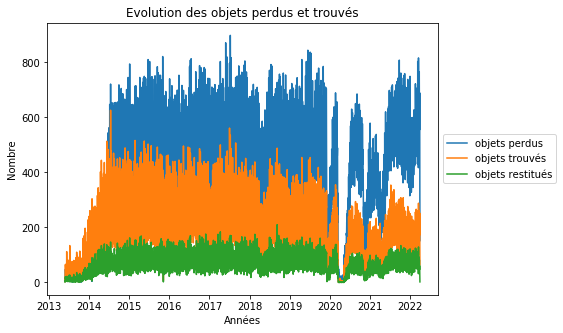

In [111]:
fig_evolution, ax = plt.subplots(figsize = (7, 5))

ax.plot(evolution_objets_perdus, label = 'objets perdus')
ax.plot(evolution_objets_trouves, label = 'objets trouvés')
ax.plot(evolution_objets_restitues, label = 'objets restitués')

ax.set_ylabel('Nombre')
ax.set_xlabel('Années')
ax.set_title("Evolution des objets perdus et trouvés")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

En utilisant la méthode de lecture au jour près, cela rend la lecture complexe. Pour plus de simplification, nous pouvons utiliser les variables créées en *6.a)* qui compte le nombre d'objets perdus ou trouvés par an, afin d'avoir une évolution globale

In [112]:
#Création de la variable 'restitués_par_an' qui compte le nombre d'objets restitués par an
restitues_par_an = dataframe_1['Date et heure de restitution'].groupby([dataframe_1.Date.dt.year]).count()

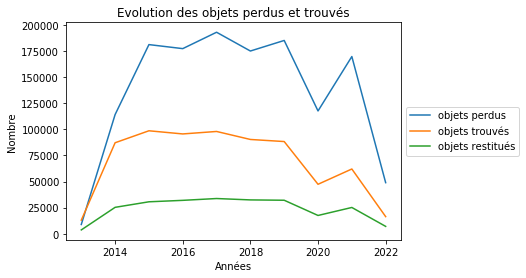

In [113]:
fig_courbe, ax = plt.subplots()

ax.plot(Perdus_par_an, label = 'objets perdus')
ax.plot(Trouves_par_an, label = 'objets trouvés')
ax.plot(restitues_par_an, label = 'objets restitués')

ax.set_ylabel('Nombre')
ax.set_xlabel('Années')
ax.set_title("Evolution des objets perdus et trouvés")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Les analyses sont les mêmes que pour le graphique précédent. Nous avons une augmentation de 2013 à 2015 par la création du système de déclaration d'objets perdus ou d'un manque de donnée. Puis une stagnation hormis en 2020-2021 dû à la crise sanitaire et aux confinements qui ont réduit le nombre de trajets et donc l'affluence dans les gares.

De plus, en comparant les trois courbes, nous pouvons observer que parmi les objets perdus, certains ont été trouvé, parmi eux ont été restitués, mais pas tous.

Pour l'année 2022, le graphique est faussé, car l'année n'est pas terminée. Donc nous avons d'un coup une forte baisse depuis 2021.
Nous allons effectuer une prévision des données pour l'année 2022 à la question 10.

## **7. Les 3 gares où il y a le plus d’objets restitués en pourcentage des objets trouvés.**

Dans un premier temps, nous pouvons créer un DataFrame qui contient le nom des gares et la Date et heure de restitution seulement, car pas tous les objets ont été restitués. Pour cela, nous utilisons la commande 'dropna()' qui permet de supprimer les lignes où nous avons des valeurs manquantes.

In [114]:
restitue = dataframe_1[['Gare', 'Date et heure de restitution']].dropna()

Nous pouvons compter le nombre de fois que chaque gare apparaît dans ce dataframe, que nous division par le nombre total d'objets restitué puis multiplé par 100 pour avoir le résultat en pourcentage. Nous arrondissons le résultat à deux chiffres après la virgule. Puis nous transformons le résultat sous la forme d'un pourcentage, cela en convertissant le résultat en 'string' afin d'ajouter le caractère '%'. Cette méthode a été utilisée dans les questions précédentes.

In [115]:
gares_objets_restitués = ((pd.DataFrame(restitue[['Gare']].value_counts())/len(restitue))*100).round(2).rename(columns = {0:"Pourcentage d'objet restitués"}).astype(str) + '%'
gares_objets_restitués.head(3)

Pourcentage d'objet restitués
Gare                                            
Paris Montparnasse                         7.54%
Paris Gare de Lyon                         6.83%
Paris Gare du Nord                         5.66%

Nous avons donc les 3 gares où il y a le plus d'objets restitués en pourcentage des objets trouvés. Cependant, précédemment, nous avons pu remarquer que dans la gare de 'Paris Gare de Lyon' il y a le plus d'objets trouvés, donc cela peut expliquer le fait qu'elle soit parmi les gares avec le plus d'objets restitués.

## **8. Affichage sur une carte de France un diagramme en bulle avec le volume d’objets déclarés perdus par gare**

### **a. Volume d’objets déclarés perdus par gare**

Le volume d'objets déclarés perdus corresponds au nombre d'objets déclaré perdus, on effectue alors un 'value_counts()'

In [116]:
volume_perdu_gare = dataframe_2[['Gare']].value_counts().reset_index(name='Volume')
volume_perdu_gare.head()

Gare  Volume
0  Paris Gare de Lyon   46951
1  Paris Montparnasse   39972
2  Paris Saint-Lazare   30081
3  Paris Gare du Nord   30043
4          Strasbourg   18949

### **b. Association de chaque gare une position GPS pour pouvoir l’afficher sur la carte**

Sur le site de la SCNF, nous avons déjà un fichier open data avec les informations correspondantes aux différentes gares : 'code_UIC', 'Intutilé plateforme', 'region', 'commune', ...
Mais aussi les coordonnées GPS de chaque gare: 'longitude', 'latitude'.

In [117]:
df_gares = pd.read_csv('https://ressources.data.sncf.com/explore/dataset/referentiel-gares-voyageurs/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B', sep = ';')

Nous allons nous servir seulement des colonnes qui nous intéresse, notamment la colonne 'Intitulé plateforme', 'Longitude' et 'Latitude'. Si nous prenons aussi, par exemple, la colonne 'Régions' et que l'on excécutera la commande 'dropna()', cela va supprimer entièrement la ligne même s'il manque juste le nom de la région. Nos choix de variables permettent d'éviter de perdre trop d'informations utiles pour des informations nécessaires.

In [118]:
info_gare = df_gares[['Intitulé plateforme',  'Longitude', 'Latitude']]
info_gare.head()

Intitulé plateforme  Longitude   Latitude
0           Remise à Jorelle   2.487751  48.893170
1                    Cerbère   3.163403  42.441773
2          Ur - Les Escaldes   1.940482  42.457481
3       Olette - Canaveilles   2.271931  42.554720
4  Prades - Molitg-les-Bains   2.429418  42.617099

Nous pouvons fusionner les deux dataframe 'info_gare' et 'volume_perdu_gare' en coordonnants les noms des Gares pour avoir les coordonnées GPS attribués aux gares et aux volumes d'objets perdu. Nous avons des villes où les coordonnées gps ne sont pas indiqués, alors nous n'allons pas les prendrons en compte.

In [119]:
gare_gps = pd.merge(volume_perdu_gare, info_gare, how="left", left_on = "Gare", right_on = "Intitulé plateforme").dropna()

#Nous pouvons supprimer une des deux colonnes avec le nom des gares car elles sont identitques
del gare_gps['Intitulé plateforme']
gare_gps.head()

Gare  Volume  Longitude   Latitude
2   Paris Saint-Lazare   30081   2.325331  48.876242
3   Paris Gare du Nord   30043   2.355151  48.880185
4           Strasbourg   18949   7.734584  48.584967
5  Bordeaux Saint-Jean   17790  -0.556697  44.825873
6            Paris Est   15400   2.358424  48.876742

Le dataframe commence à 2 car le 0 et 1 correspond respectivement à la gare "Paris Gare de Lyon" et "Paris Montparnasse". Mais dans le dataframe info_gare, celles-ci n'ont pas de coordonnées gps, alors on utilise 'dropna()' pour enlever les gares qui ne possèdent pas de coordonnées GPS. Le problème ce que cela enlève des gares importantes.

### **c. Affichage de la donnée sur la carte**

In [120]:
#génération de la carte de france 
france_circle = folium.Map(location = [46.506876, 2.278206], zoom_start = 6)

#code html qui sera dans les informations des popup 
html_1 = """<br><strong>Gare : </strong></br>"""
html_2 = """<br><strong>Volume d'objets perdus : </strong></br>"""

#On effectue une boucle pour chaque ligne du dataframe 'gare_gps'
for _,row in gare_gps.iterrows():
    
    #paramètres du popup: le contenu et la taille avec le module 'branca' qui permet la générération de langage html
    iframe = branca.element.IFrame(html_1 + row.Gare + html_2 + str(row.Volume), width=200, height=130)
    
    #génération des markers
    folium.Circle(
            [row.Latitude,row.Longitude], #coordonnée GPS
            popup = folium.Popup(iframe),
            tooltip = row.Gare,
            color = 'red',
            fill = True, #remplissage des bulles
            fill_opacity = 0.5,  #opacité des différentes bulles
            radius = row.Volume,    #la taille des bulles représente l'importance du Nombre du type d'objet perdus par gare
        ).add_to(france_circle)

#affichage de la carte    
france_circle

In [121]:
#enregistrement de la carte sous format html
france_circle.save('france_circle.html')

Nous pouvons observer que les villes qui ont le plus d'objets perdus sont (dans l'ordre): les gares de Paris, la gare de Strasbourg, la gare de Bordeaux Saint-Jean, la gare de Lille Europe.

### **d. Ajout d'un sélecteur de “type d’objets” pour avoir une carte par catégorie**

In [122]:
#On attribue les différents Type d'objets à chaque gare et on compte le nombre de nature d'objets par chaque type d'objet dans chaque villes
type_objets_gare = dataframe_2.groupby(["Gare", "Type d'objets"]).size().reset_index(name = "Nombre")

#fusion du dataframe gare_gps et type_objets_gare
select = pd.merge(gare_gps, type_objets_gare)
select.head()

Gare  Volume  Longitude   Latitude  \
0  Paris Saint-Lazare   30081   2.325331  48.876242   
1  Paris Saint-Lazare   30081   2.325331  48.876242   
2  Paris Saint-Lazare   30081   2.325331  48.876242   
3  Paris Saint-Lazare   30081   2.325331  48.876242   
4  Paris Saint-Lazare   30081   2.325331  48.876242   

                                       Type d'objets  Nombre  
0  Appareils électroniques, informatiques, appare...    4457  
1                Articles d'enfants, de puériculture     187  
2                Articles de sport, loisirs, camping      76  
3                                  Articles médicaux     319  
4                Bagagerie: sacs, valises, cartables   10519

In [123]:
#carte de france 
france_select = folium.Map(location = [46.506876, 2.278206], zoom_start = 6)

layers = {}   
colors = {}

#Création des couches (layers) et attribution de couleur par couche
for type_obj in select["Type d'objets"].unique():
    layers[type_obj] =  folium.FeatureGroup(name = type_obj)
    colors[type_obj] = f'rgb{tuple(np.random.randint(0,255,3))}' #attribution de couleurs aléatoires
    

#code html qui sera dans les informations des popup 
html_1 = """<br><strong>Gare: </strong></br>"""
html_2 = """<br><strong>Types d'objets: </strong></br>"""
html_3 = """<br><strong>Nombre: </strong></br>"""

#On effectue une boucle pour chaque ligne du dataframe 'select'
for _,row in select.iterrows():
    #paramètres du popup: le contenu et la taille avec le module 'branca' qui permet la générération de langage html
    iframe = branca.element.IFrame(html_1 + row.Gare + html_2 + row["Type d'objets"] + html_3 + str(row.Nombre), width=300, height=150)
    
    layer = layers[row["Type d'objets"]]
    color = colors[row["Type d'objets"]]
        
    #génération des markers pour chaque couche
    folium.Circle(
            [row.Latitude,row.Longitude],
            popup = folium.Popup(iframe),
            tooltip = row.Gare,
            color = color,
            fill = True, #remplissage des bulles
            fill_opacity = 0.5,  #opacité des différentes bulles
            radius = row.Nombre*2,    #la taille des bulles représente l'importance du nombre du type d'objet perdus par jours
        ).add_to(layer)

#Ajout des couches à la carte de France
for layer in layers.values():
    france_select.add_child(layer)

#Ajout du contrôle des couches à la carte de France
france_select.add_child(LayerControl())

#Affichage de la carte de France
france_select

In [124]:
#enregistrement de la carte sous format html
france_select.save('france_select.html')

Pour plus de simplification, on a attribué des couleurs aléatoirement aux différentes couches. Avant d'enregistrer la carte, il est plus intéressant d'exécuter le code quelques fois pour obtenir un ensemble de couleurs lisible. Mais cela est une perte de temps, voir une perte d'argent pour une entreprise qui aurait a effectuer ce type de code.

En zoomant que la carte et sur une grande ville, par exemple Marseille, on peut observer les différentes couches de bulles qui représentent les différents types d'objets. Globalement, on peut apercevoir que c'est la couche qui représente le type d'objet 'Bagagerie' qui a les bulles les plus importantes. Les voyageurs ont plus tendance à perdre leurs bagages que les autres type d'objets. 

## **9. Data visualization**

### **Pie Chart**

In [125]:
types_objets_trouves = dataframe_1["Type d'objets"].value_counts()
types_objets_perdus = dataframe_2["Type d'objets"].value_counts()

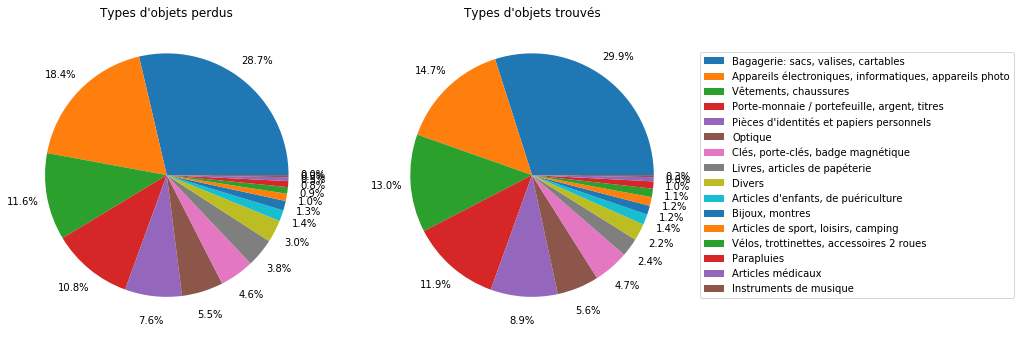

In [126]:
fig_pie, (ax1,ax2) = plt.subplots(1,2,figsize = (12,12))

#Pie chart numéro 1
ax1.pie(types_objets_perdus, autopct = '%1.1f%%', pctdistance = 1.2)
ax1.set_title("Types d'objets perdus")

#Pie chart numéro 2
ax2.pie(types_objets_trouves, autopct = '%1.1f%%', pctdistance = 1.2)
ax2.set_title("Types d'objets trouvés")

#la legende pour 'types_objets_perdus' et 'types_objets_trouvés' est la même donc ont prend un des deux
plt.legend(types_objets_perdus.index, bbox_to_anchor = (2.1, 0.5), loc = "center right")

plt.show()

Nous constatons que le type d'objet le plus perdu et "Bagerie: sacs, valises, cartables", heureusement pour les individus, c'est le type d'objets le plus trouvés. Cependant, ce graphique pourrait emmener l'entreprise SNCF à sensibiliser les voyageurs sur les pertes de Bagagerie et de faire attention. Mais cela peut être fait pour diminuer le nombre d'objets perdus. Nous pouvons constater que les Pie Chart des types d'objets perdus et trouvés sont très semblables. Cela s'explique par le nombre d'objets perdus de base.

### **Treemap**

Nous allons créer un Treemap. Pour cela, nous pouvons utiliser le dataframe 'type_objets_gare' créé précédemment, qui contient le nom des gare ainsi que le nombre de types d'objet perdu par gare. 

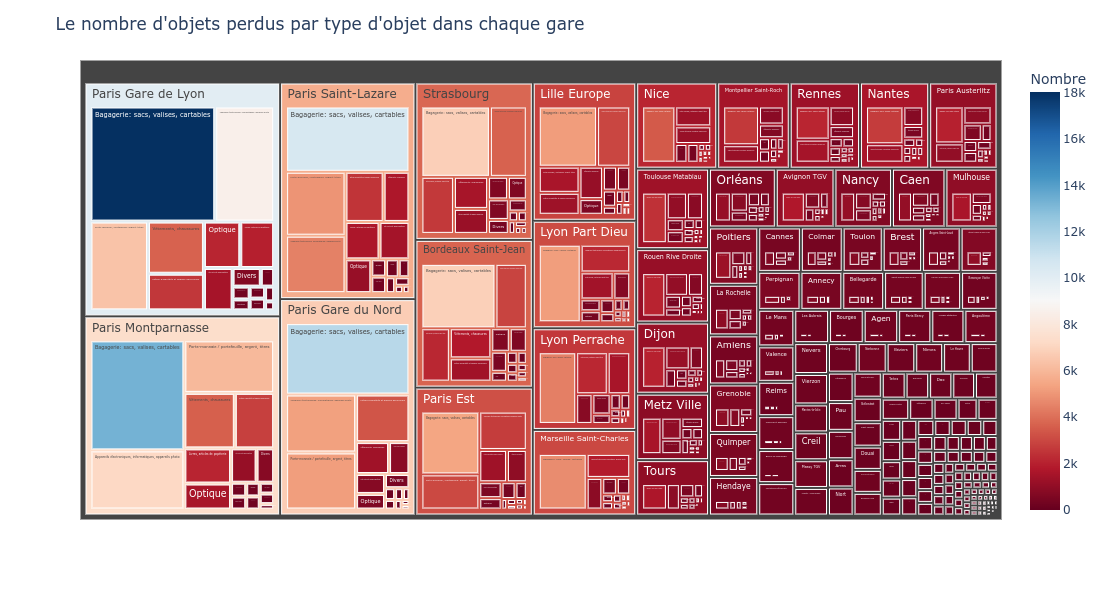

In [127]:
fig_treemap = px.treemap(type_objets_gare,
                 path=['Gare', "Type d'objets"],
                 values='Nombre', #poid du type d'objets dans chaque Gare,
                 color='Nombre', #variable sur quoi se base l'échelle de couleur
                 color_continuous_scale='RdBu' #couleur de l'échelle
                  )

fig_treemap.update_layout(title="Le nombre d'objets perdus par type d'objet dans chaque gare", width=1000, height=600)
fig_treemap.show()

Nous pouvons cliquer sur chaque gare afin d'observer les différents type d'objets perdus. Lorsque l'on place le curseur sur le nom de la Gare cela nous affiche des informations dont 'Nombre_sum' qui représente le volume total d'objets perdus dans cette gare, qui résulte de la somme des objets perdus par types d'objets du DataFrame. En analysant, nous pouvons observer que sont les mêmes données que la colonne 'volume' du dataframe 'volume_perdu_gare'.

## **10. Création d'un modèle de machine learning qui pourra prédire le nombre d’objets perdus en 2022.**


Pour prédire le nombre d'objets perdus en 2022, nous allons utiliser la variable 'Perdus_par_an' créé à la question 6. Mais nous devons d'abord supprimer la ligne correspondante à l'année 2022.

In [128]:
reg_years = Perdus_par_an.reset_index(name = "Nombre").drop(9) #on supprime la ligne de l'année 2022
reg_years

Date  Nombre
0  2013    8853
1  2014  114106
2  2015  181098
3  2016  177241
4  2017  192931
5  2018  174955
6  2019  185066
7  2020  117561
8  2021  169673

In [129]:
regr = LinearRegression()

In [130]:
regr.fit(reg_years[["Date"]], reg_years["Nombre"])

LinearRegression()

In [131]:
regr.intercept_

-22016468.69444446

In [132]:
regr.coef_

array([10988.25])

La fonction de regression est: $f(x) = 10988.25x-22016468.7$

In [133]:
#Prédiction pour l'année 2022
regr.predict([[2022]])

/home/leaaumagy/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([201772.80555556])

Le nombre d'objet perdu prédit pour l'année 2022 est 201 772

Comme nous avons effectué une régression linéaire, nous avons donc le nombre d'objets prédit qui augmente en 2022. Pour l'année 2022, il serait intéressant d'embaucher plus d'agents afin d'aider les voyageurs à retrouver leurs objets perdus.

On aurait pu essayer de faire un modèle de machine learning un peu avancer et comparer les erreurs empiriques entre les modèles. Cependant, cela ne sera pas très pertinent, car le nombre de colonnes autant que le nombre d'observations dans le temps ne sont pas élevées.

## **11. Production d'une image PNG au format 2000 x 2000 qui affiche les résultats à toutes les questions précédentes.**

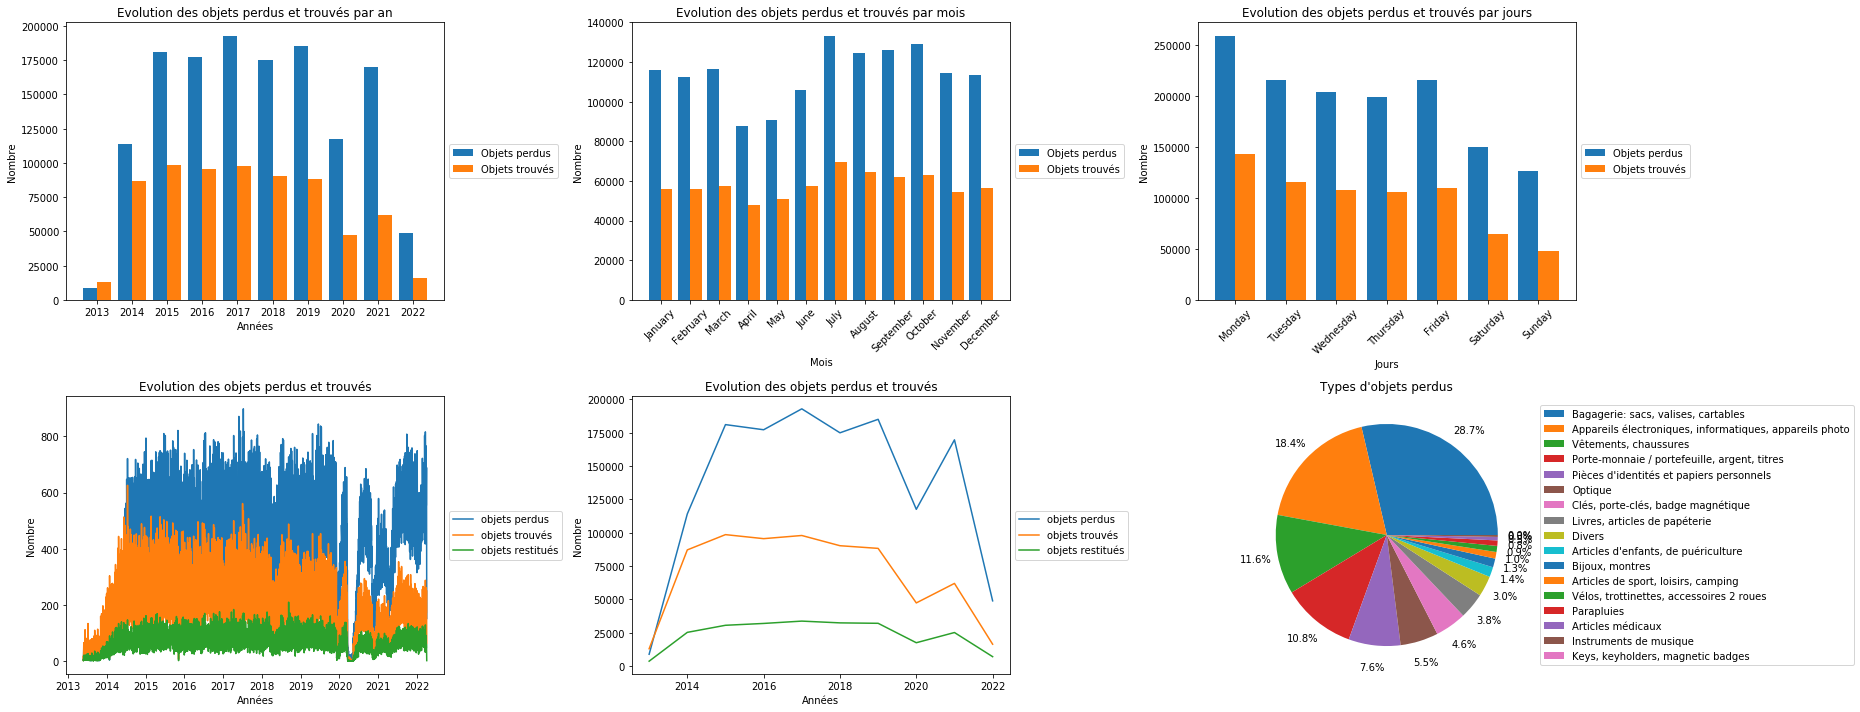

In [144]:
figure, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25,10))
  
ax1.bar(Perdus_par_an.index - 0.2, Perdus_par_an, width = 0.4, label='Objets perdus')
ax1.bar(Trouves_par_an.index + 0.2, Trouves_par_an, width = 0.4, label='Objets trouvés')
ax1.set_ylabel('Nombre')
ax1.set_xlabel('Années')
ax1.set_title("Evolution des objets perdus et trouvés par an")
ax1.set_xticks(Perdus_par_an.index)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))


labels = Perdus_par_mois.index   
x = np.arange(len(labels)) 
ax2.bar(x - 0.2, Perdus_par_mois, width = 0.4, label='Objets perdus')
ax2.bar(x + 0.2, Trouves_par_mois, width = 0.4, label='Objets trouvés')
ax2.set_ylabel('Nombre')
ax2.set_xlabel('Mois')
ax2.set_title("Evolution des objets perdus et trouvés par mois")
ax2.set_xticks(x)   #affichage de tous les indices de l'axe x
ax2.set_xticklabels(labels, rotation='45')    #on remet les labels sur les ticks de l'axe x
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

labels = Perdus_par_jours.index  
x = np.arange(len(labels)) 
ax3.bar(x - 0.2, Perdus_par_jours, width = 0.4, label='Objets perdus') 
ax3.bar(x + 0.2, Trouves_par_jours, width = 0.4, label='Objets trouvés')
ax3.set_ylabel('Nombre')
ax3.set_xlabel('Jours')
ax3.set_title("Evolution des objets perdus et trouvés par jours")
ax3.set_xticks(x)   #affichage de tous les indices de l'axe x
ax3.set_xticklabels(labels, rotation='45')   #on remet les labels sur les ticks de l'axe x
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax4.plot(evolution_objets_perdus, label = 'objets perdus')
ax4.plot(evolution_objets_trouves, label = 'objets trouvés')
ax4.plot(evolution_objets_restitues, label = 'objets restitués')
ax4.set_ylabel('Nombre')
ax4.set_xlabel('Années')
ax4.set_title("Evolution des objets perdus et trouvés")
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5.plot(Perdus_par_an, label = 'objets perdus')
ax5.plot(Trouves_par_an, label = 'objets trouvés')
ax5.plot(restitues_par_an, label = 'objets restitués')
ax5.set_ylabel('Nombre')
ax5.set_xlabel('Années')
ax5.set_title("Evolution des objets perdus et trouvés")
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax6.pie(types_objets_perdus, autopct = '%1.1f%%', pctdistance = 1.2)
ax6.set_title("Types d'objets perdus")
ax6.legend(types_objets_perdus.index, bbox_to_anchor = (2.2, 0.5), loc = "center right")


plt.tight_layout()
plt.show()

In [145]:
#enregistrement de la figure sous format 'png'
figure.savefig('Graphique_SNCF.png', orientation='landscape', format='png')

Nous aurions pu aussi enregistrer directement nos figures sur un document pdf pour plus de facilité

In [146]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('Graphiques_SNCF.pdf')

fig_année.savefig(pp, format='pdf', bbox_inches = 'tight')
fig_mois.savefig(pp, format='pdf', bbox_inches = 'tight')
fig_jours.savefig(pp, format='pdf',bbox_inches = 'tight')
fig_courbe.savefig(pp, format='pdf', bbox_inches = 'tight')
fig_evolution.savefig(pp, format='pdf', bbox_inches = 'tight')
fig_pie.savefig(pp, format='pdf', bbox_inches = 'tight')

pp.close()